# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Импорты и функции для выполнения проекта

In [1]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Импортируем необходимые библиотеки для работы 
import pandas as pd
from math import *
import numpy as np
from scipy import stats as st
from numpy.random import RandomState

# Метрики и оОбработка данных
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif


# Графическое отображение
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns


# Модели обучения
from sklearn.linear_model import LogisticRegression, LinearRegression



import warnings
warnings.filterwarnings("ignore") #импортировал после завершения проекта, для удобного код-ревью

#Зададим константы
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [5]:
# Функция для отображения информации о датасете
def show_info(df):
    print('Количество строк выборки составляет:',df.shape[0],'\n')
    display('Первые пять строк', df.head())
    print('Общая информация о данных\n')
    print(df.info())
    display('Описание',df.describe().T)
    print('Количество явных дубликатов составляет',df.duplicated().sum())

In [6]:
#Функция отображения гистограм и боксплотов для исследовательского анализа
def search_plot(df_col, title_name, bins):

    mean = df_col.mean()
    median = df_col.median()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"{title_name}", fontsize=13)
    
    sns.histplot(df_col, bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(title_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    ax[0].axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
    ax[0].axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[0].legend()

    sns.boxplot(x=df_col, ax=ax[1], color='pink')
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='green', linestyle='-.')
    ax[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    
    display(df_col.describe().T)
    print('')
    
    stat, p = st.shapiro(df_col)
    alpha = 0.1  # Уровень значимости
    if p > alpha:
        print("По тесту Шапиро-Уилка: Распределение похоже на нормальное")
    else:
        print("По тесту Шапиро-Уилка: Распределение отличается от нормального")

In [7]:
def probability_income(income, mean_income, lower, upper, bins, title):
    
    fig, ax = plt.subplots(figsize=(12, 7))

    sns.histplot(income, bins=bins, kde=True, ax=ax)
    ax.set_title(f"График распределения вероятности прибыли в {title}", fontsize=13)
    ax.set_xlabel('Прибыль,млрд.')
    ax.set_ylabel('Частота')
    ax.grid(True)


    formatter = FuncFormatter(lambda x, _: f'{x * 1e-9:.1f}B')  # Делим на миллиард и добавляем "B"
    ax.xaxis.set_major_formatter(formatter)

    # Линии для среднего и квантилей
    ax.axvline(mean_income, color='purple', linestyle='--', label=f'Среднее = {mean_income * 1e-9:.2f}B')
    ax.axvline(lower, color='red', linestyle='-.', label=f'Нижний квантиль 2.5% = {lower * 1e-9:.2f}B')
    ax.axvline(upper, color='blue', linestyle='-.', label=f'Верхний квантиль 97.5% = {upper * 1e-9:.2f}B')
    ax.legend()

In [8]:
def train_model(df): 
    
# Выделяем признаки и таргет
    X = df.drop(['product'], axis = 1)
    y = df['product']
    
# Разделяем выборки на тренировочную и тестовую
    X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
    )
    
# Используем масштабирование данных
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    
# Инициализация линейной регрессии
    lr = LinearRegression()
    
# Обучение модели
    lr.fit(X_train_scaled, y_train)
    
# Предсказание модели
    prediction = lr.predict(X_test_scaled)
    
# Расчет среднего объема
    oil_mean_region = prediction.sum() / len(prediction)

# Оценка rmse-метрики
    rmse = mean_squared_error(y_test, prediction) ** 0.5 
    return rmse, oil_mean_region, prediction, y_test

## Загрузка и подготовка данных

In [9]:
try:
    df_1 = pd.read_csv('/datasets/geo_data_0.csv', sep =',')
    df_2 = pd.read_csv('/datasets/geo_data_1.csv', sep =',')
    df_3 = pd.read_csv('/datasets/geo_data_2.csv', sep =',')
    
except:
    df_1 = pd.read_csv('geo_data_0.csv', sep =',')
    df_2 = pd.read_csv('geo_data_1.csv', sep =',')
    df_3 = pd.read_csv('geo_data_2.csv', sep =',')

    
df_list=[df_1, df_2, df_3]


In [10]:
i=1
for df in df_list:
    print(f'------------ ДАТАСЕТ №{i} ------------')
    show_info(df)
    print(f'\n------------------------------------')
    i+=1

------------ ДАТАСЕТ №1 ------------
Количество строк выборки составляет: 100000 



'Первые пять строк'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Количество явных дубликатов составляет 0

------------------------------------
------------ ДАТАСЕТ №2 ------------
Количество строк выборки составляет: 100000 



'Первые пять строк'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Количество явных дубликатов составляет 0

------------------------------------
------------ ДАТАСЕТ №3 ------------
Количество строк выборки составляет: 100000 



'Первые пять строк'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Количество явных дубликатов составляет 0

------------------------------------


In [11]:
# Уберем id в индексы
df_1 = df_1.drop(['id'], axis = 1)
df_2 = df_2.drop(['id'], axis = 1)
df_3 = df_3.drop(['id'], axis = 1)


In [12]:
df_list = [df_1, df_2, df_3]

### Итог  по загрузке данных

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

1. Пропуски и дубликаты отсутствуют.
    
2. С каждого региона представлено по 10000 скважин    
       
3. Среднее значение объемов запаса нефти вышевсего в 1 и 3 регионе(92.5 и 95 тыс. баррелей), во втором  68.8 тыс. баррелей

## Исследовательский анализ

### Первый регион

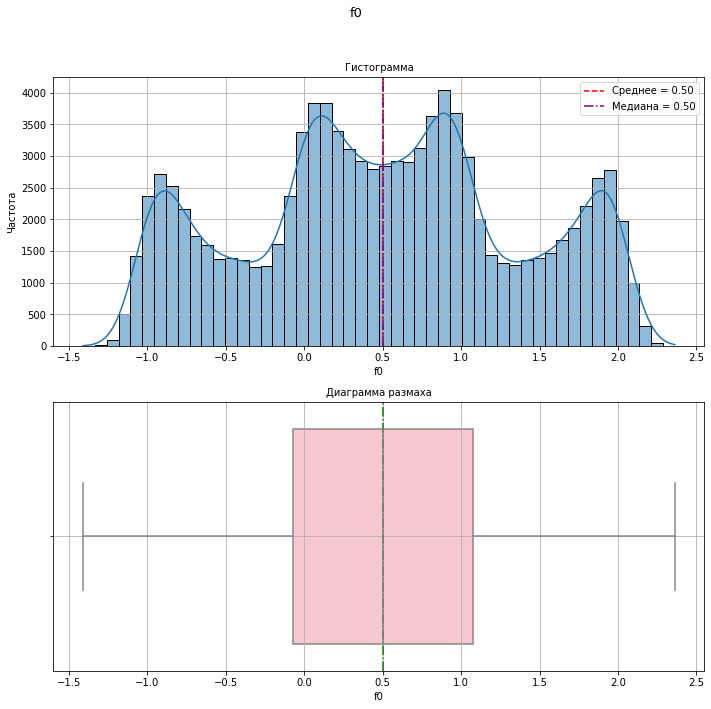

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [13]:
search_plot(df_1['f0'],'f0',50)

- Распределение содержит неколько пиковых значений.   
- Выбросы отсутствуют.    
- Среднее и медиана равны. 

-----

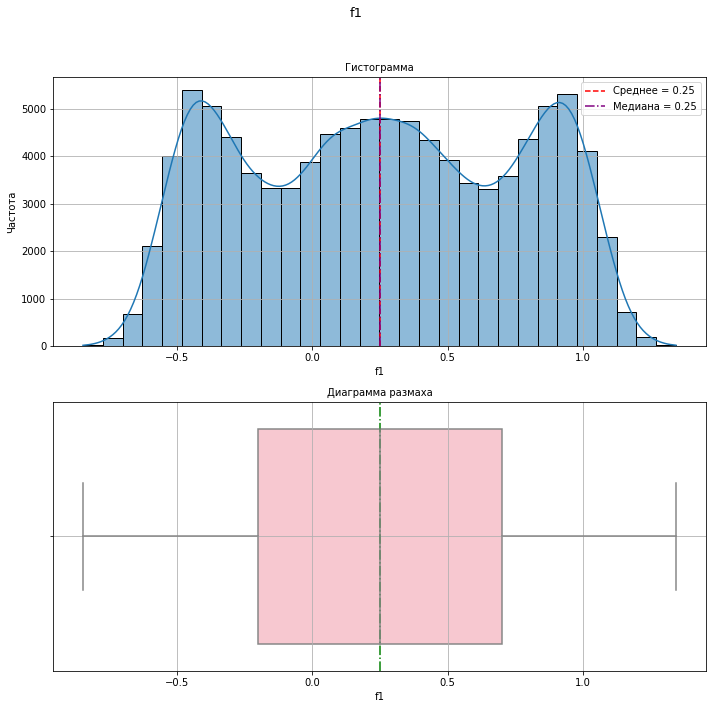

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [14]:
search_plot(df_1['f1'],'f1',30)

- Распределение содержит неколько пиковых значений.   
- Выбросы отсутсвуют.    
- Среднее и медиана равны. 


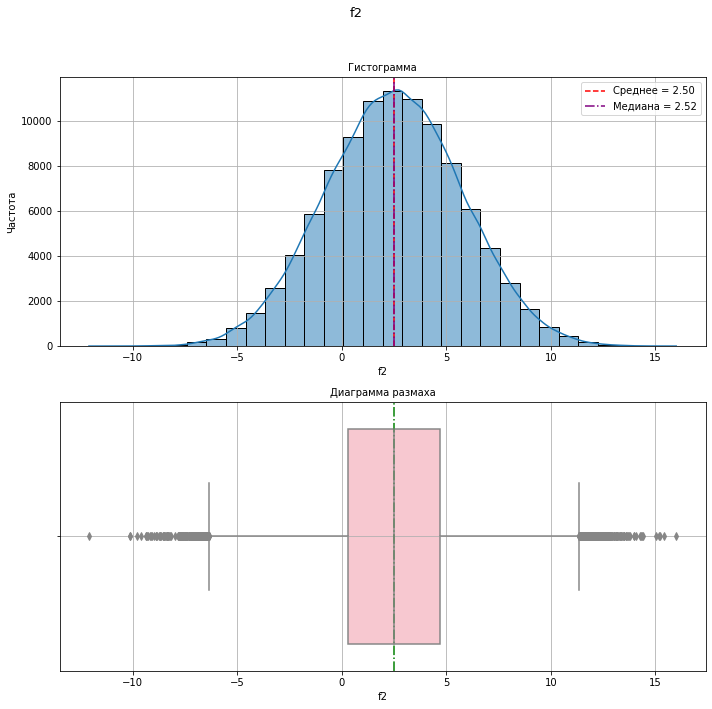

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [15]:
search_plot(df_1['f2'],'f2',30)

- Распределение похоже на нормальное, но с выбросами.   
- Наблюдаются выбросы.    
- Среднее и медиана почти равны. 

> **Выбросы удалять не будем, так как по условию задачи нет конкретного пояснения, что они обозначают. Также было отмечено, что эти признаки значимы**

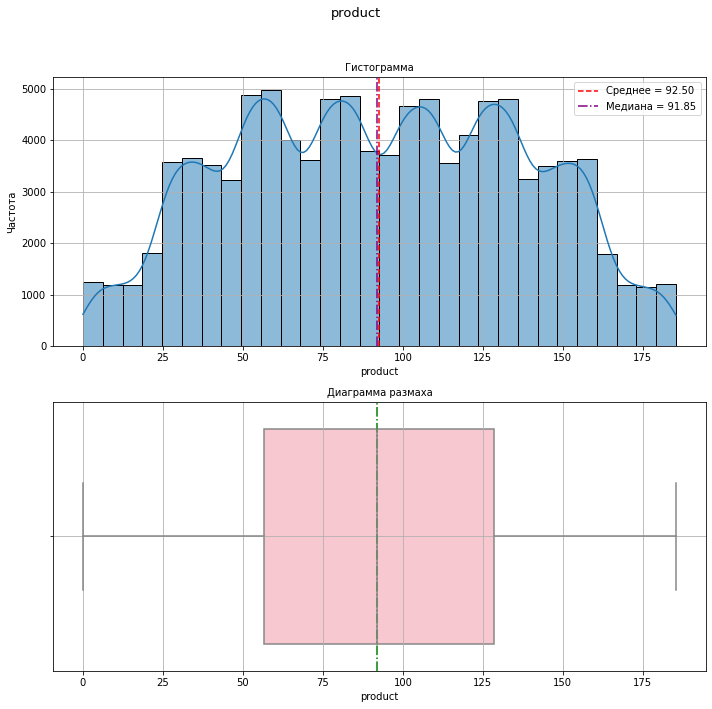

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [16]:
search_plot(df_1['product'],'product',30)

- Распределение содержит неколько пиковых значений.
- Выбросы отсутсвуют.
- Среднее и медиана равны.
- Нет отрицательных значений.

### Второй регион

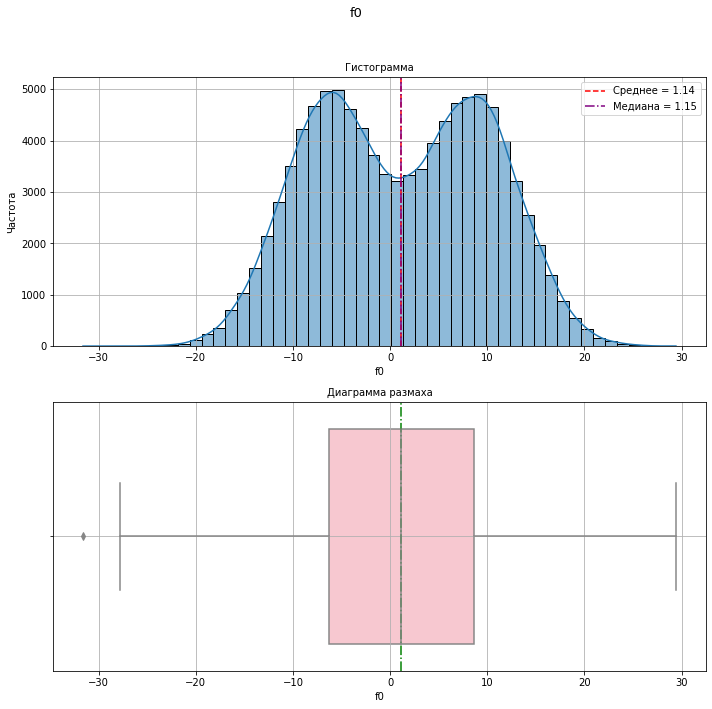

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [17]:
search_plot(df_2['f0'],'f0',50)

- Распределение бимодальное.   
- Наблюдаются выброс.    
- Среднее и медиана почти равны. 

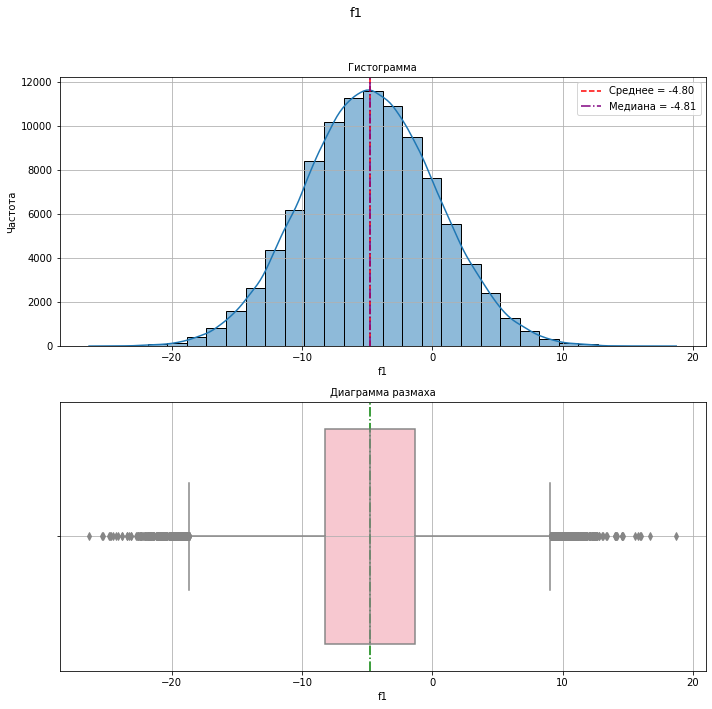

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64


По тесту Шапиро-Уилка: Распределение похоже на нормальное


In [18]:
search_plot(df_2['f1'],'f1',30)

- Распределение похоже на нормальное, но с выбросами.   
- Наблюдаются выбросы.    
- Среднее и медиана почти равны. 

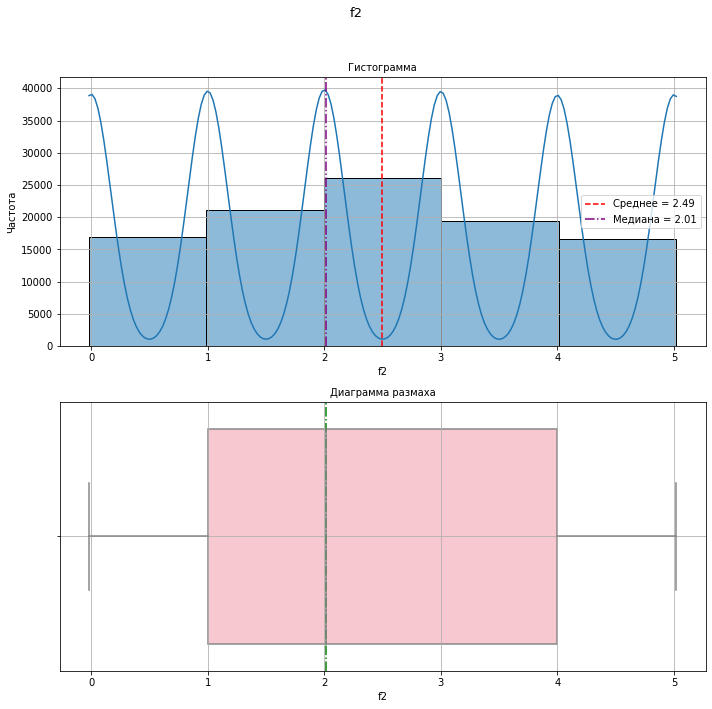

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [19]:
search_plot(df_2['f2'],'f2',5)

- Распределение похоже на нормальное.   
- Выбросы отсутсвуют.    
- Среднее значение смещено вправо. 

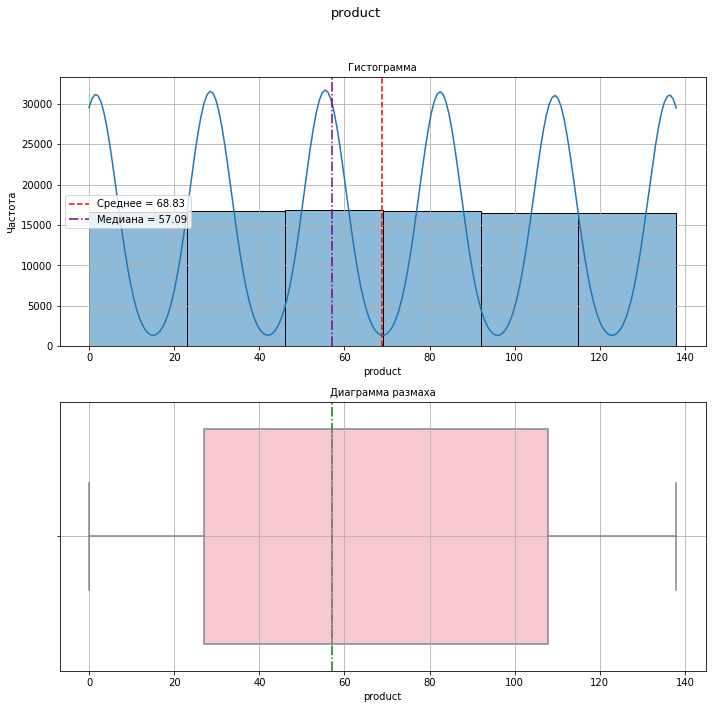

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [20]:
search_plot(df_2['product'],'product',6)

- Распределение содержит неколько пиковых значений.   
- Отсутствуют выбросы.    
- Среднее значение смещено вправо. 

### Третий регион

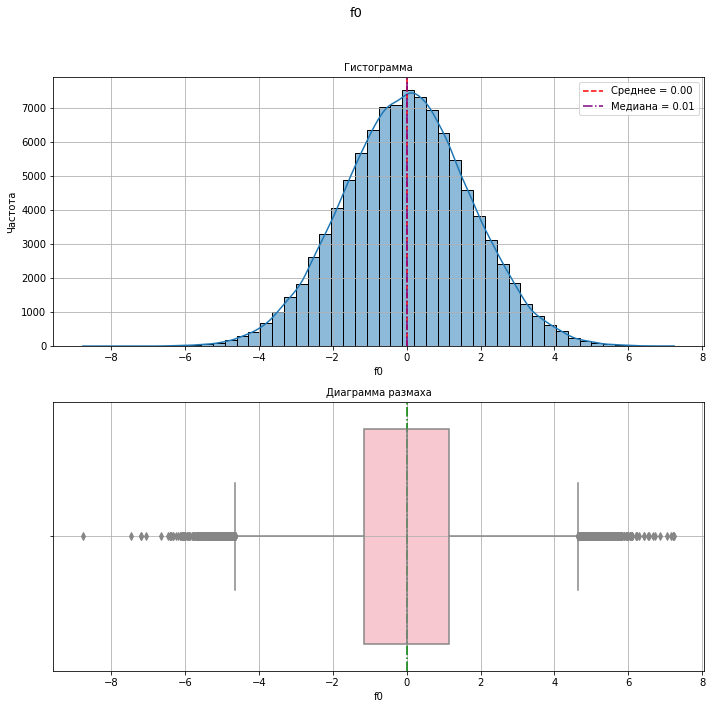

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64


По тесту Шапиро-Уилка: Распределение похоже на нормальное


In [21]:
search_plot(df_3['f0'],'f0',50)

- Распределение похоже на нормальное, но с выбросами.   
- Наблюдаются выбросы.    
- Среднее и медиана почти равны. 

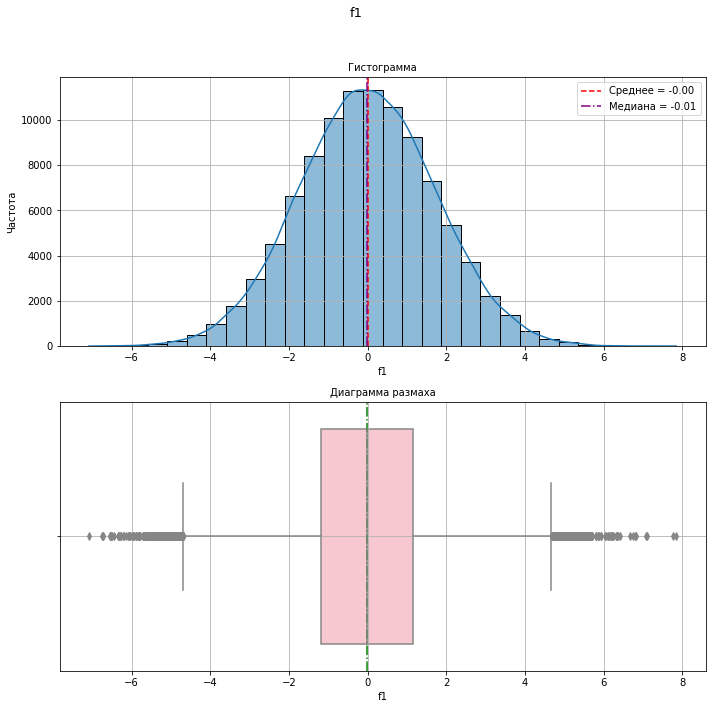

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64


По тесту Шапиро-Уилка: Распределение похоже на нормальное


In [22]:
search_plot(df_3['f1'],'f1',30)

- Распределение похоже на нормальное, но с выбросами.   
- Наблюдаются выбросы.    
- Среднее и медиана почти равны. 

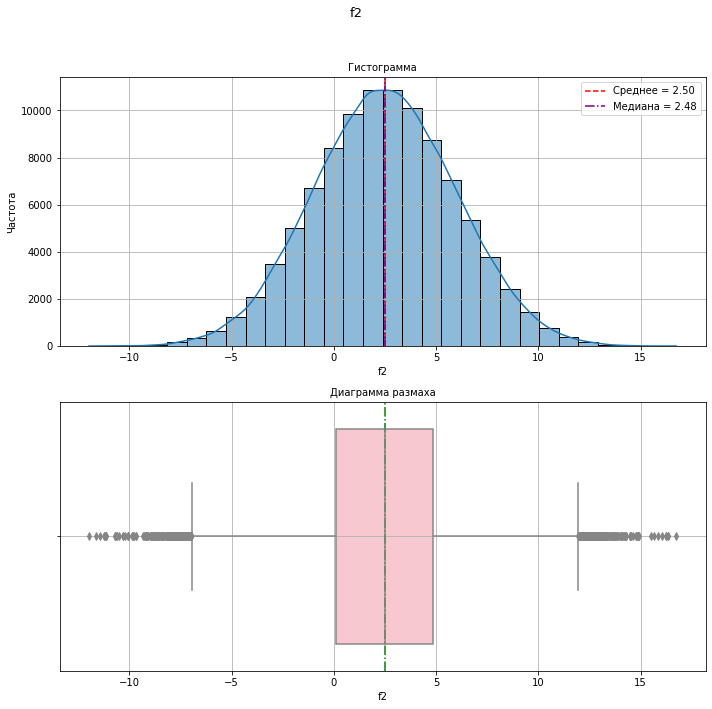

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [23]:
search_plot(df_3['f2'],'f2',30)

- Распределение похоже на нормальное, но с выбросами.   
- Наблюдаются выбросы.    
- Среднее и медиана почти равны. 

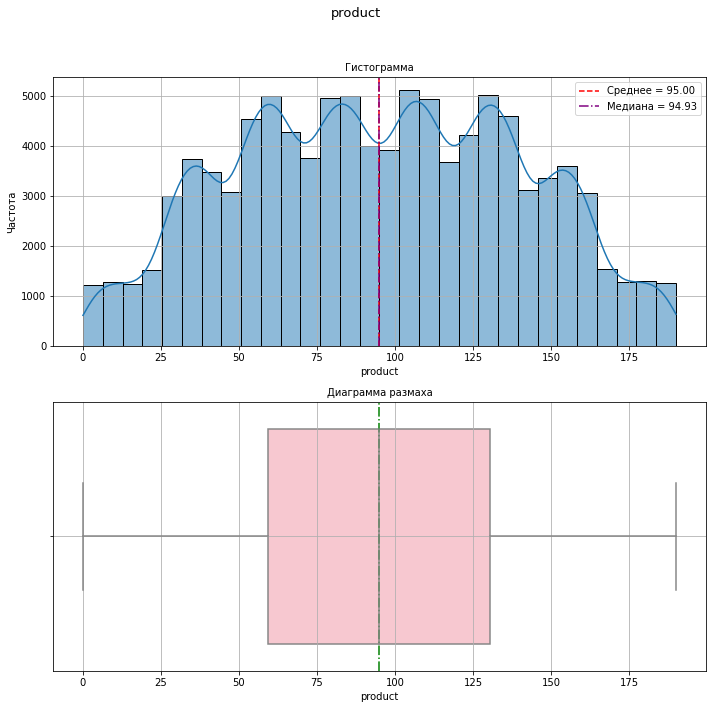

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [24]:
search_plot(df_3['product'],'product',30)

- Распределение содержит неколько пиковых значений.   
- Отсутствуют выбросы.    
- Среднее значение смещено вправо. 

### Итог по анализу данных

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

Был проведен исследовательский анализ данных и сформулированы следующие выводы:
    
**Регион №1:**    
    
* Признаки не имеют нормального распределения

* Наблюдаются выбросы в f2    

        
**Регион №2:**    
  
* Признаки не имеют нормального распределения

* Наблюдаются выбросы в f1   
    
    
**Регион №3:**    

* Признаки не имеют нормального распределения

* Наблюдаются выбросы во всех входных признаках       
    
    
    
> **Выбросы удалять не будем, так как по условию задачи нет конкретного пояснения, что они обозначают. Также было отмечено, что эти признаки значимы**

## Обучение модели

Обучим и сохраним данные с помощью функции `train_model`. Сохраним значения предсказаний, правильные значения, оценку модели rmse и средний запас предсказанного сырья

In [25]:

rmse_list = []
oil_mean_region_list = []
prediction_list = []
target_valid_list = []

# Обучение и сохранение данных в списки
for i in df_list:
    rmse, oil_mean_region, prediction, target_valid = train_model(i)
    rmse_list.append(rmse)
    oil_mean_region_list.append(oil_mean_region)
    prediction_list.append(prediction)
    target_valid_list.append(target_valid)

# Создадим датафрейм с полученными значениями    
df_region = pd.DataFrame({
    'region': [1,2,3],
    'oil_mean_region': oil_mean_region_list,
    'rmse': rmse_list
})   

In [26]:
pred_1, pred_2, pred_3 = prediction_list
target_1, target_2, target_3 = target_valid_list
oil_mean_region_1, oil_mean_region_2, oil_mean_region_3 = oil_mean_region_list

In [27]:
len(pred_1)

25000

In [28]:
df_region

,region,oil_mean_region,rmse
0,1,92.558015,37.756735
1,2,68.858206,0.899997
2,3,94.949667,40.144744


### Итог по Обучению модели

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

**Среднее значение запасов нефти**
- **Регион 1**: Среднее значение запасов нефти составляет **92.56**.
- **Регион 2**: Среднее значение запасов нефти составляет **68.86**. Это самый низкий показатель среди всех регионов.
- **Регион 3**: Среднее значение запасов нефти составляет **94.95**. Это самый высокий показатель, что может указывать на более успешное использование нефтяных ресурсов в этом регионе.

**Корень из среднеквадратичной ошибки (RMSE)**
- **Регион 1**: RMSE составляет **37.76**. Это значение говорит о том, что предсказания по доходу в этом регионе имеют достаточно высокую ошибку.
- **Регион 2**: RMSE составляет **0.90**. Это значение указывает на то, что предсказания в этом регионе очень точны, что может быть связано меньшими колебаниями в данных.
- **Регион 3**: RMSE составляет **40.14**. Это также высокое значение, что говорит о значительной ошибке в предсказаниях дохода от нефти.

**Сравнительный анализ**
- **Регион 2** демонстрирует наименьшое среднее количество нефти, но также и наименьшую ошибку в предсказаниях. Это может указывать на стабильность и предсказуемость доходов

## Подготовка к расчёту прибыли

Введем необходимые константы

In [29]:
BUDGET = 10**10
COST = 450000
SEARCH_POINTS = 500
TOTAL_POINTS = 200
RISK_POINT = 2.5


In [30]:
zero_value = BUDGET/(COST*TOTAL_POINTS)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины составляет {round(zero_value,3)} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины составляет 111.111 тыс. баррелей


**Выввод:**    
В каждом из трёх регионов средний запас сырья скважины меньше полученного значения достаточного объёма сырья. Необходимо тщательнее отбирать лучшие скважины для получения прибыли

## Расчёт прибыли и рисков 

In [31]:
# Создадим функцию которая с помощью бутстрепа будет перебирать 1000 случайных выборок из датафрейма
# для определения доверительного интервала и средней прибыли региона для добычи нефти
def bootstrap_income(predictions, target):
    
    bootstrap_samples = 1000
    state = RandomState(12345)
    cashflow_list=[]
    pred_series = pd.Series(predictions)
    
    for i in range(bootstrap_samples):
        # Возьмем случаную выборку из 500 скважин
        target_sample = target.reset_index(drop=True).sample(n=SEARCH_POINTS, replace=True, random_state=state)
        
        # Отберем те же скважины по индексу из предсказанных значений и отсортируем по убыванию
        pred_sample = pred_series[target_sample.index].sort_values(ascending=False)
        
        # В фактических значениях сортируем по индексам предсказанных значений и отбираем первые 200 скважин
        target_sort = target_sample[pred_sample.index][:TOTAL_POINTS]
        
        # Рассчитываем прибыль и добавляем в список
        cash = target_sort.sum() * COST - BUDGET
        cashflow_list.append(cash)
                
    values = pd.Series(cashflow_list)
    
    lower = int(values.quantile(0.025))
    upper = int(values.quantile(0.975))
    
    risk = len(values[values<0]) / len(values) * 100
    
    return values, int(values.mean()), lower, upper, risk

In [32]:
income_1, mean_income_1, lower_1, upper_1, risk_1 = bootstrap_income(pred_1,target_1)
income_2, mean_income_2, lower_2, upper_2, risk_2 = bootstrap_income(pred_2,target_2)
income_3, mean_income_3, lower_3, upper_3, risk_3 = bootstrap_income(pred_3,target_3)

Риск убытков в Регионе № 1 составляет 6.10%


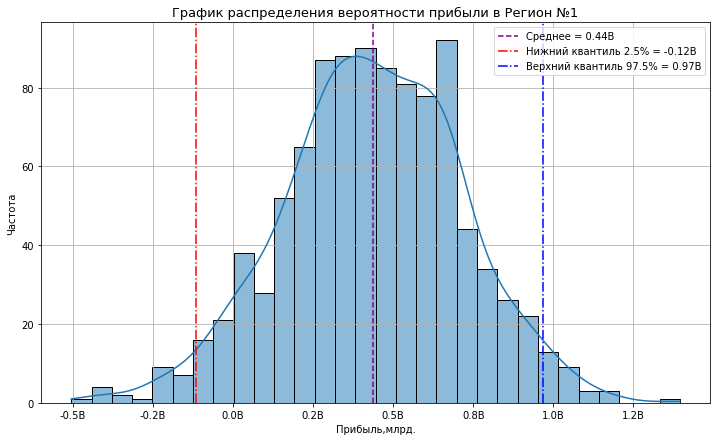

In [33]:
probability_income(income_1, mean_income_1, lower_1, upper_1, bins=30, title='Регион №1')
print(f'Риск убытков в Регионе № 1 составляет {risk_1:.2f}%')

Риск убытков в Регионе № 2 составляет 1.10%


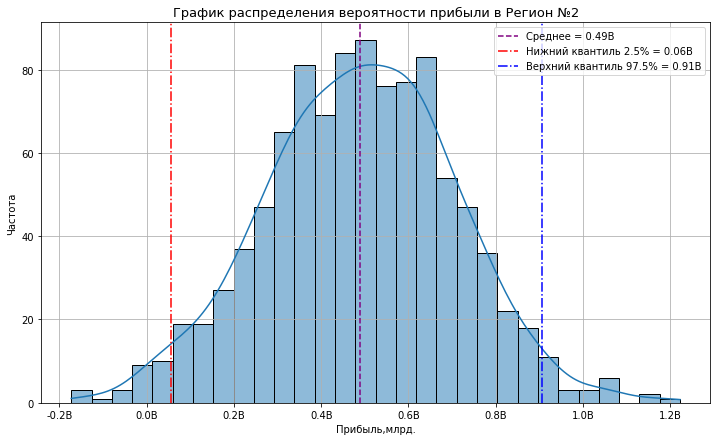

In [34]:
probability_income(income_2, mean_income_2, lower_2, upper_2, bins=30, title='Регион №2')
print(f'Риск убытков в Регионе № 2 составляет {risk_2:.2f}%')

Риск убытков в Регионе № 3 составляет 7.10%


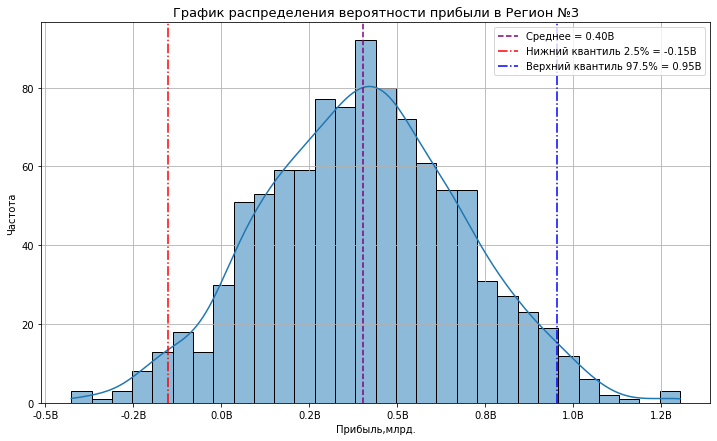

In [35]:
probability_income(income_3, mean_income_3, lower_3, upper_3, bins=30, title='Регион №3')
print(f'Риск убытков в Регионе № 3 составляет {risk_3:.2f}%')

In [ ]:
fig, ax= plt.subplots(figsize=(12, 7))

sns.pairplot(df_1, hue = "product")

ax.set_title(f"График распределения вероятности прибыли", fontsize=13)
ax.set_xlabel('Прибыль,млрд.')
ax.set_ylabel('Частота')
ax.grid(True)


formatter = FuncFormatter(lambda x, _: f'{x * 1e-9:.1f}B')  # Делим на миллиард и добавляем "B"
ax.xaxis.set_major_formatter(formatter)

# Линии для среднего и квантилей
ax.axvline(mean_income_1, color='purple', linestyle='--', label=f'Среднее = {mean_income_1 * 1e-9:.2f}B')
ax.axvline(lower_1, color='red', linestyle='-.', label=f'Нижний квантиль 2.5% = {lower_1 * 1e-9:.2f}B')
ax.axvline(upper_1, color='blue', linestyle='-.', label=f'Верхний квантиль 97.5% = {upper_1 * 1e-9:.2f}B')
ax.legend()


## Общий Итог

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

**Средняя прибыль**
- **Регион 1**: Среднее значение прибыли составляет **440 млн.**.
- **Регион 2**: Среднее значение прибыли составляет **490 млн.**. Это самый высокий показатель среди всех регионов.    
- **Регион 3**: Среднее значение прибыли составляет **400 млн.**. Это самый низкий показатель среди всех регионов.

**Доверительный интервал**
- **Регион 1**: от *-116 млн.* до *966 млн.*
- **Регион 2**: от *55 млн.* до *905 млн.*
- **Регион 3**: от *-153 млн.* до *952 млн.*

**Оценка рисков убытка**
- **Регион 1**: *6.1%*.
- **Регион 2**: *1.1%*. Самый низкий показатель
- **Регион 3**: *7.1%*. Самый высокий показатель
    
    
**Выводы**

- **Регион 2** демонстрирует наивысшую среднюю прибыль (*490 млн.*) и самый низкий риск убытка (*1.1%*). Это делает его наиболее привлекательным для инвестиций.
    
- Доверительный интервал Регион 2 также показывает, что даже в худшем сценарии прибыль будет положительной (*от 55 млн. до 905 млн.*), что добавляет уверенности в его выбор.
    
**Рекомендация**
- На основе проведенного анализа, для данной модели МО рекомендуется выбрать Регион 2 для добычи нефти, так как он предлагает наивысшую среднюю прибыль и минимальный риск убытка, что делает его наиболее выгодным вариантом для инвестиций.
- Если есть возможность получить более качественные данные или дополнительные для увеличения качества модели, то можно добиться положительного результата для 1 и 3 региона, так как там средний запас выше, чем во втором регионе, но из-за недостаточного обучения модели нельзя гарантировать безубыточную добычу нефти, что оставляет 2 регион в фаворитах